In [2]:
%%bash
# Download TF checkpoints in data/models folder

wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
tar -xvzf inception_v3_2016_08_28.tar.gz -C ../../deep_learning/data/models/
rm inception_v3_2016_08_28.tar.gz

wget http://download.tensorflow.org/models/adv_inception_v3_2017_08_18.tar.gz
tar -xvzf adv_inception_v3_2017_08_18.tar.gz -C ../../deep_learning/data/models/
rm adv_inception_v3_2017_08_18.tar.gz

inception_v3.ckpt
adv_inception_v3.ckpt.data-00000-of-00001
adv_inception_v3.ckpt.index
adv_inception_v3.ckpt.meta


--2018-04-06 05:50:26--  http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 216.58.216.176, 2607:f8b0:400a:807::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|216.58.216.176|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100885009 (96M) [application/x-tar]
Saving to: ‘inception_v3_2016_08_28.tar.gz’

     0K .......... .......... .......... .......... ..........  0% 2.93M 33s
    50K .......... .......... .......... .......... ..........  0% 7.04M 23s
   100K .......... .......... .......... .......... ..........  0% 10.5M 19s
   150K .......... .......... .......... .......... ..........  0% 12.6M 16s
   200K .......... .......... .......... .......... ..........  0% 27.1M 13s
   250K .......... .......... .......... .......... ..........  0% 15.8M 12s
   300K .......... .......... .......... .......... ..........  0% 40.4M 11s
   350K .......... .......... 

In [3]:
# Reference: https://github.com/marcoancona/DeepExplain/blob/master/examples/inception_tensorflow.ipynb
import pandas as pd
import numpy as np
from sklearn import metrics

import tensorflow as tf
from tensorflow.contrib.slim.nets import inception

from skater.util.dataops import json_validator
from skater.util.image_ops import load_image, show_image, normalize, noisy
from skater.core.local_interpretation.dnni.deep_interpreter import DeepInterpreter
from skater.core.visualizer.image_visualizer import visualize

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [4]:
slim = tf.contrib.slim

file_directory = '../../../Skater/build/lib/skater/util/model_specific/imagenet_label.json'
json_data = open(file_directory).read()
json_validator(json_data)

True

In [22]:
resized_img = load_image('../../deep_learning/data/images/baseball_player_2.jpg', 299, 299)
input_resized_img = resized_img.reshape((1, 299, 299, 3))

In [23]:
# from skimage.color import rgb2gray
# gray_image = rgb2gray(input_resized_img)

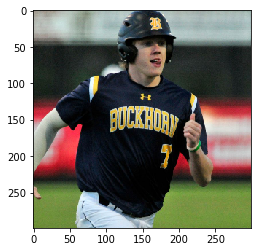

In [24]:
%matplotlib inline
show_image(input_resized_img[0])

In [25]:
# Load Inception V3 model from Tensorflow Slim, restore section
# from checkpoint and run the classifier on the input data
num_classes = 1001

# Select the model here. Use adv_inception_v3 to use the weights of
# an adversarially trained Inception V3. Explanations will be more sparse.

checkpoint = '../../deep_learning/data/models/inception_v3.ckpt'

In [26]:
# Load the labels related to imagenet dataset
import json
tf.reset_default_graph()
sess = tf.Session()
labels = json.loads(json_data)

In [27]:
with DeepInterpreter(session=sess, graph=sess.graph) as de:
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(X, num_classes=num_classes, is_training=False)

    logits = end_points['Logits']
    yi = tf.argmax(logits, 1)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)

    input_X = input_resized_img
    label_index = sess.run(yi, feed_dict={X: input_X})
    print("Predicted Label: {}".format(labels[str(label_index[0])]))

INFO:tensorflow:Restoring parameters from ../../deep_learning/data/models/inception_v3.ckpt
Predicted Label: ballplayer, baseball player


In [28]:
with DeepInterpreter(session=sess) as de:
    relevancy_scores = {
       'elrp': de.explain('elrp', tf.reduce_max(logits, 1), X, input_X),
    }
    print ("success...")

2018-04-06 05:53:08,653 - skater.core.local_interpretation.dnni.deep_interpreter - INFO - all supported relevancy scorers OrderedDict([('elrp', <class 'skater.core.local_interpretation.dnni.relevance_scorer.LRP'>)])
2018-04-06 05:53:08,653 - skater.core.local_interpretation.dnni.deep_interpreter - INFO - DeepInterpreter: executing relevance type class <class 'skater.core.local_interpretation.dnni.relevance_scorer.LRP'>


success...


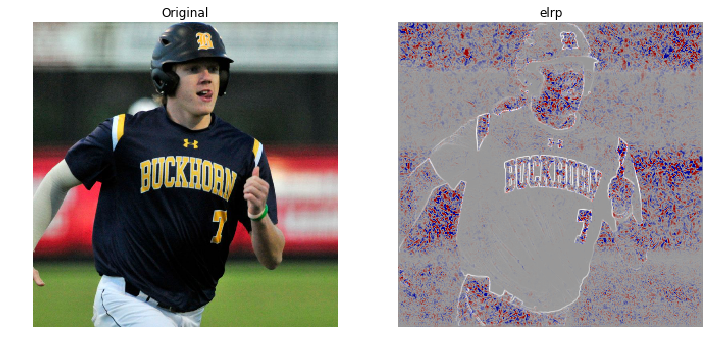

In [29]:
# Plot relevance
%matplotlib inline
import matplotlib.pyplot as plt

xs = [input_X[0]]
n_cols = int(len(relevancy_scores)) + 1
n_rows = len(input_X) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(xs):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original')
    ax.axis('off')
    for j, r_type in enumerate(relevancy_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevancy_scores[r_type][i], original_input_img=xi, axis=axj, percentile=99, alpha=.4).set_title(r_type)

### Adding noise to the image

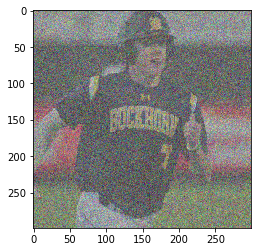

In [34]:
noise_img = normalize(noisy("gauss", resized_img))
input_resized_img = noise_img.reshape((1, 299, 299, 3))
show_image(input_resized_img[0])

In [35]:
import json
tf.reset_default_graph()
sess = tf.Session()

with DeepInterpreter(session=sess, graph=sess.graph) as de:
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(X, num_classes=num_classes, is_training=False)

    logits = end_points['Logits']
    yi = tf.argmax(logits, 1)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)

    input_X = input_resized_img
    label_index = sess.run(yi, feed_dict={X: input_X})
    print("Predicted Label: {}".format(labels[str(label_index[0])]))

INFO:tensorflow:Restoring parameters from ../../deep_learning/data/models/inception_v3.ckpt
Predicted Label: ballplayer, baseball player


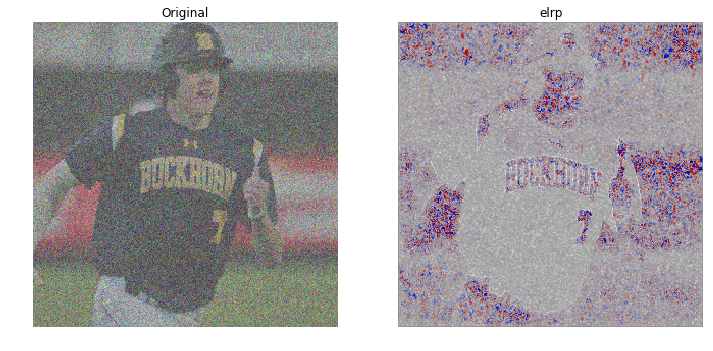

In [36]:
# Plot relevance
%matplotlib inline
import matplotlib.pyplot as plt

xs = [input_X[0]]
n_cols = int(len(relevancy_scores)) + 1
n_rows = len(input_X) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(xs):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original')
    ax.axis('off')
    for j, r_type in enumerate(relevancy_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevancy_scores[r_type][i], original_input_img=xi, axis=axj, percentile=99, alpha=.4).set_title(r_type)